In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


In [2]:
#Prepare Dataset
# load data
train = pd.read_csv("train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

In [34]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net,self).__init__()
        
        #convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        #max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2=nn.ReLU()
        
        #max pool2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #fully connected 1
        
        self.fc1=nn.Linear(32*4*4,1000)
        self.fc2=nn.Linear(1000,10000)
        self.fc3=nn.Linear(10000,100)
        self.fc4=nn.Linear(100,10)

    def forward(self,x):
        #convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        #max pool 1
        out = self.maxpool1(out)
        
        #convolution 2
        out=self.cnn2(out)
        out = self.relu2(out)
        
        #max pool 2
        out=self.maxpool2(out)
        out=out.view(out.size(0), -1)
        
        #fully connected 1
        
        out=self.fc1(out)
        out=self.fc2(out)
        out=self.fc3(out)
        out=self.fc4(out)
        
        
        return out
         
        

In [35]:
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [5]:
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [6]:
model = CNN_Net()
error = nn.CrossEntropyLoss()

learning_rate = 0.1

optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

In [36]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.item() , accuracy))

Iteration: 500  Loss: 0.015343818813562393  Accuracy: 98 %
Iteration: 1000  Loss: 0.02079717628657818  Accuracy: 98 %
Iteration: 1500  Loss: 0.012804960831999779  Accuracy: 98 %
Iteration: 2000  Loss: 0.005655336193740368  Accuracy: 98 %


In [37]:
import matplotlib.pyplot as plt 

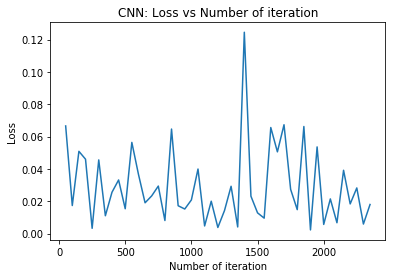

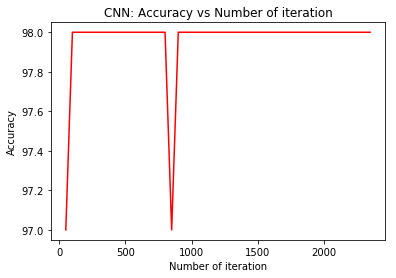

In [38]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [39]:
test = pd.read_csv("test.csv",dtype = np.float32).values

In [40]:
nb_test = test.shape[0]
nb_test

28000

In [41]:
Y_data  = test.reshape(test.shape[0], 1, 28, 28)
Y_data  = Y_data.astype(float)
Y_data /= 255.0
Y_data  = torch.from_numpy(Y_data);

In [42]:
final_prediction = np.ndarray(shape = (nb_test, 2), dtype=int)
for each_sample in range(nb_test):
    sample_data = Variable(Y_data[each_sample:each_sample+1].clone())
    sample_data = sample_data.type(torch.FloatTensor)

    sample_out = model(sample_data)
    pred = torch.max(sample_out, 1)
    final_prediction[each_sample][0] = 1 + each_sample
    final_prediction[each_sample][1] = pred[1][0]
    if (each_sample + 1) % 2000 == 0:
        print("Total tested = %d" %(each_sample + 1))

print ('5. Generating submission file')

submission = pd.DataFrame(final_prediction, dtype=int, columns=['ImageId', 'Label'])
submission.to_csv('submission1.csv', index=False, header=True)


Total tested = 2000
Total tested = 4000
Total tested = 6000
Total tested = 8000
Total tested = 10000
Total tested = 12000
Total tested = 14000
Total tested = 16000
Total tested = 18000
Total tested = 20000
Total tested = 22000
Total tested = 24000
Total tested = 26000
Total tested = 28000
5. Generating submission file
